In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score, cross_val_predict, learning_curve
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.svm import SVC
from sklearn.calibration import LabelEncoder
from sklearn.preprocessing import label_binarize
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, ConfusionMatrixDisplay, classification_report, confusion_matrix, roc_auc_score, roc_curve, auc, precision_recall_curve
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from itertools import cycle
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import joblib
import numpy as np
import matplotlib.pyplot as plt

# DATA LABELLING

In [3]:
df = pd.read_csv('output/vader_labelled8.csv')
X_cleaned = df['lemmatized']
y_cleaned = df['Sentiment']
df.head(5)

,full_text,created_at,cleaned,translated,case_fold,token,stop,lemmatized,Positive,Negative,Neutral,Compound,Sentiment
0,Inilah 2 unit Rumah Tapak Jabatan Menteri yang...,Fri Mar 29 11:48:49 +0000 2024,Inilah 2 unit Rumah Tapak Jabatan Menteri yang...,b These are the 2 units of Landed Houses for M...,b these are the units of landed houses for mi...,"['b', 'these', 'are', 'the', 'units', 'of', 'l...","['b', 'units', 'landed', 'houses', 'ministeria...","['b', 'unit', 'land', 'house', 'ministerial', ...",0.000,0.000,1.000,0.0000,Neutral
1,Alhamdulillah terima kasih berkenan mengunjung...,Fri Mar 29 02:34:41 +0000 2024,Alhamdulillah terima kasih berkenan mengunjung...,b Alhamdulillah thank you for visiting the Ind...,b alhamdulillah thank you for visiting the ind...,"['b', 'alhamdulillah', 'thank', 'you', 'for', ...","['b', 'alhamdulillah', 'thank', 'visiting', 'i...","['b', 'alhamdulillah', 'thank', 'visit', 'indo...",0.161,0.000,0.839,0.6369,Positive
2,Pengamat Kritik 2 Proyek Milik Konglomerat Pen...,Thu Mar 28 23:39:00 +0000 2024,Pengamat Kritik 2 Proyek Milik Konglomerat Pen...,b Observers Criticize 2 Projects Owned by Cong...,b observers criticize projects owned by congl...,"['b', 'observers', 'criticize', 'projects', 'o...","['b', 'observers', 'criticize', 'projects', 'o...","['b', 'observer', 'criticize', 'project', 'own...",0.141,0.127,0.732,0.0772,Positive
3,Wow‼️Terlihat dari pinggir jalan Gedung-gedung...,Thu Mar 28 06:04:01 +0000 2024,Wow‼️Terlihat dari pinggir jalan Gedunggedung ...,b Wow Seen from the side of the road towering ...,b wow seen from the side of the road towering ...,"['b', 'wow', 'seen', 'from', 'the', 'side', 'o...","['b', 'wow', 'seen', 'side', 'road', 'towering...","['b', 'wow', 'see', 'side', 'road', 'tower', '...",0.132,0.000,0.868,0.5859,Positive
4,Waktu ngedrone roll off trafo PLN di pelabuhan...,Thu Mar 28 03:03:32 +0000 2024,Waktu ngedrone roll off trafo PLN di pelabuhan...,b When droned to roll off a PLN transformer at...,b when droned to roll off a pln transformer at...,"['b', 'when', 'droned', 'to', 'roll', 'off', '...","['b', 'droned', 'roll', 'pln', 'transformer', ...","['b', 'drone', 'roll', 'pln', 'transformer', '...",0.072,0.000,0.928,0.3400,Positive


In [3]:
df.shape

(3435, 13)

In [15]:
def remove_first_word(text):
    if isinstance(text, str):
        words = text.split()
        return ' '.join(words[1:]) if len(words) > 1 else ''
    return text

# Apply the function to the 'lemmatized' column
df['lemmatized'] = df['lemmatized'].apply(remove_first_word)
X_cleaned = df['lemmatized']

In [16]:
X_cleaned.head(10)

0    'land', 'house', 'ministerial', 'position', 'c...
1    'thank', 'visit', 'indonesian', 'office', 'mr'...
2    'criticize', 'project', 'own', 'conglomerate',...
3    'see', 'side', 'road', 'tower', 'building', 'a...
4    'roll', 'pln', 'transformer', 'east', 'kaliman...
5    'proposal', 'participate', 'move', 'ikn', 'nus...
6    'vvip', 'ikn', 'airport', 'development', 'proj...
7    'ikn', 'nusantara', 'consider', 'profitable', ...
8    'residence', 'construction', 'become', 'massiv...
9    'ikn', 'nusantara', 'consider', 'profitable', ...
Name: lemmatized, dtype: object

In [3]:
sentiment_counts = df['Sentiment'].value_counts(2)
print("Jumlah data positif:", sentiment_counts.get('Positive', 0))
print("Jumlah data negatif:", sentiment_counts.get('Negative', 0))
print("Jumlah data netral:", sentiment_counts.get('Neutral', 0))

Jumlah data positif: 1915
Jumlah data negatif: 448
Jumlah data netral: 1072


In [1]:
df.shape()

NameError: name 'df' is not defined

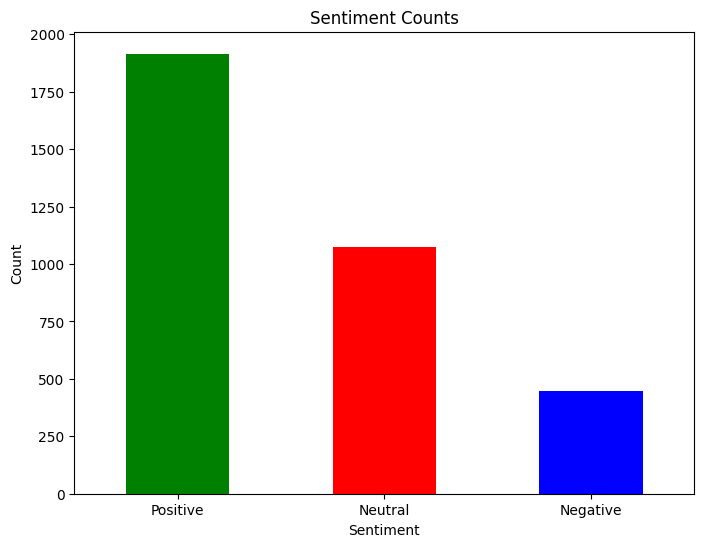

In [5]:
plt.figure(figsize=(8, 6))
sentiment_counts.plot(kind='bar', color=['green', 'red', 'blue'])
plt.title('Sentiment Counts')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

# OUTLIERS REMOVAL

In [5]:
# Removing outliers based on text length
df['text_length'] = df['lemmatized'].apply(lambda x: len(x.split()))
q1 = df['text_length'].quantile(0.25)
q3 = df['text_length'].quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

df_cleaned = df[(df['text_length'] >= lower_bound) & (df['text_length'] <= upper_bound)]

X_cleaned = df_cleaned['lemmatized']
y_cleaned = df_cleaned['Sentiment']

# TF-IDF VECTORIZER

In [17]:
vectorizer = TfidfVectorizer(stop_words='english', max_features=10000, ngram_range=(1, 2))
X_vectorized = vectorizer.fit_transform(X_cleaned)

nb_model = BernoulliNB()
svm_model = SVC(probability=True)

nb_pipeline = Pipeline([
    ('classifier', nb_model)
])

svm_pipeline = Pipeline([
    ('classifier', svm_model)
])

print(X_vectorized)

  (0, 3162)	0.2626121720019024
  (0, 6110)	0.3289936142398063
  (0, 3930)	0.6264102948834867
  (0, 2474)	0.22486453797588116
  (0, 3075)	0.05761419035182066
  (0, 1359)	0.185351782628003
  (0, 6108)	0.2356216097374862
  (0, 3012)	0.4121254004995702
  (0, 3922)	0.34176682689409743
  (1, 8789)	0.259985943139492
  (1, 8092)	0.2988447113273874
  (1, 4986)	0.2988447113273874
  (1, 9298)	0.23263761749085526
  (1, 7753)	0.230016361074465
  (1, 1037)	0.20549920803758578
  (1, 2500)	0.17308929463148212
  (1, 8788)	0.249810405253629
  (1, 1785)	0.11878348460488948
  (1, 1272)	0.249810405253629
  (1, 2991)	0.22757602973338836
  (1, 8091)	0.2664347979212838
  (1, 7271)	0.28450309617637126
  (1, 6371)	0.2385464499495172
  (1, 4552)	0.20077609917987052
  (1, 4970)	0.16926169626608065
  :	:
  (3433, 2220)	0.18509184058549474
  (3433, 2842)	0.21437173882568553
  (3433, 2841)	0.1958981798444046
  (3433, 773)	0.1958981798444046
  (3433, 1075)	0.1958981798444046
  (3433, 9277)	0.18509184058549474
  (3433

# CROSS VALIDATION KFOLD (NAIVE BAYES)


ROC AUC Score: 0.8229197069748282


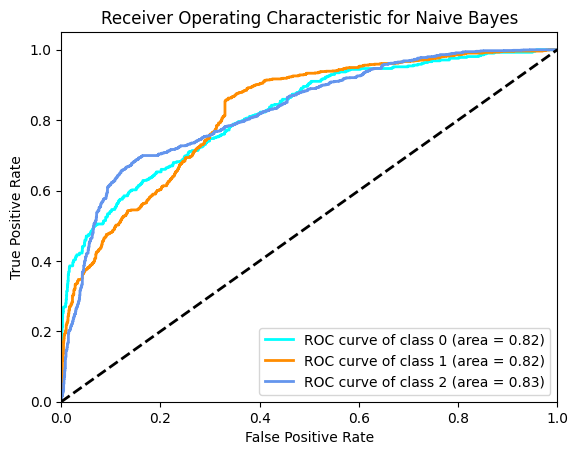

In [21]:
y_pred_cv = cross_val_predict(nb_model, X_vectorized, y_cleaned, cv=10, method='predict_proba')

# Calculate ROC AUC score for multi-class classification
roc_auc = roc_auc_score(y_cleaned, y_pred_cv, multi_class='ovr')
print(f"\nROC AUC Score: {roc_auc}")

y_bin = label_binarize(y_cleaned, classes=np.unique(y_cleaned))
n_classes = y_bin.shape[1]

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_pred_cv[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
            label=f'ROC curve of class {i} (area = {roc_auc[i]:0.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Naive Bayes')
plt.legend(loc="lower right")
plt.show()

# CROSS VALIDATION K-FOLD (SVM)


ROC AUC Score: 0.8956122210219881


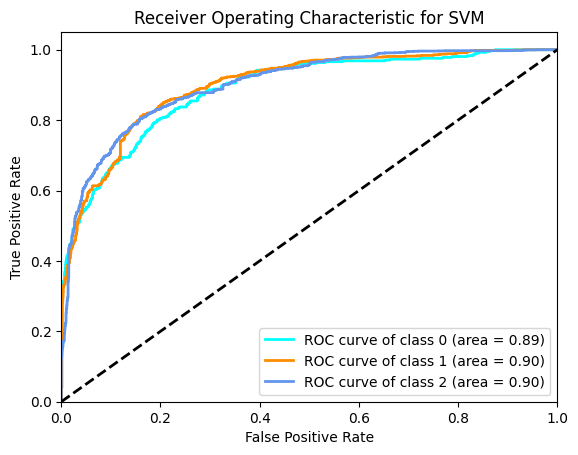

In [22]:
svm_model.fit(X_vectorized, y_cleaned)
y_pred_cv = cross_val_predict(svm_model, X_vectorized, y_cleaned, cv=10, method='predict_proba')

# Calculate ROC AUC score for multi-class classification
roc_auc = roc_auc_score(y_cleaned, y_pred_cv, multi_class='ovr')
print(f"\nROC AUC Score: {roc_auc}")

y_bin = label_binarize(y_cleaned, classes=np.unique(y_cleaned))
n_classes = y_bin.shape[1]

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_pred_cv[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
            label=f'ROC curve of class {i} (area = {roc_auc[i]:0.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for SVM')
plt.legend(loc="lower right")
plt.show()

# BALANCING DATA

In [12]:
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_vectorized, y_cleaned)

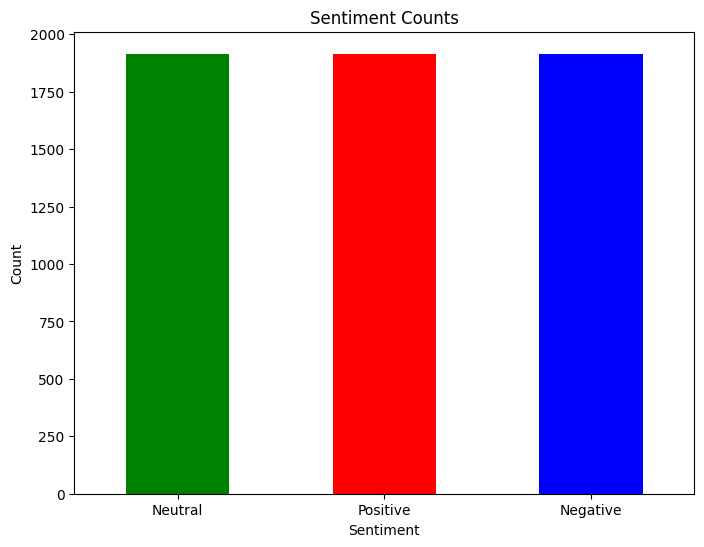

In [8]:
Sentiment_balanced_counts = y_resampled.value_counts()
plt.figure(figsize=(8, 6))
Sentiment_balanced_counts.plot(kind='bar', color=['green', 'red', 'blue'])
plt.title('Sentiment Counts')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

# GRID SEARCH

In [18]:
nb_param_grid = {
    'classifier__alpha': [0.1, 1, 10]
}

svm_param_grid = {
    'classifier__C': [0.1, 1, 10]
}

nb_gs = GridSearchCV(nb_pipeline, param_grid=nb_param_grid, scoring='accuracy')
svm_gs = GridSearchCV(svm_pipeline, param_grid=svm_param_grid, scoring='accuracy')

nb_gs.fit(X_vectorized, y_cleaned)
svm_gs.fit(X_vectorized, y_cleaned)

best_nb_model = nb_gs.best_estimator_
best_svm_model = svm_gs.best_estimator_

# K-FOLD STRATIFIED VALIDATION

In [19]:
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# K-FOLD CROSS VALIDATION

In [15]:
scores_test_nb = cross_val_score(best_nb_model, X_resampled, y_resampled, cv=10)
for i in range(10):
  print("Hasil Akurasi Naive Bayes Iterasi ke -", i+1, " : {0:2}".format(scores_test_nb[i,]*100))
print("\n","Rata-Rata Akurasi dari Naive Bayes menggunakan Cross Validation :", scores_test_nb.mean()*100)

Hasil Akurasi Naive Bayes Iterasi ke - 1  : 91.86691312384472
Hasil Akurasi Naive Bayes Iterasi ke - 2  : 90.57301293900186
Hasil Akurasi Naive Bayes Iterasi ke - 3  : 75.41589648798521
Hasil Akurasi Naive Bayes Iterasi ke - 4  : 92.05175600739372
Hasil Akurasi Naive Bayes Iterasi ke - 5  : 99.63031423290202
Hasil Akurasi Naive Bayes Iterasi ke - 6  : 92.42144177449168
Hasil Akurasi Naive Bayes Iterasi ke - 7  : 90.57301293900186
Hasil Akurasi Naive Bayes Iterasi ke - 8  : 95.74861367837339
Hasil Akurasi Naive Bayes Iterasi ke - 9  : 93.16081330868762
Hasil Akurasi Naive Bayes Iterasi ke - 10  : 90.37037037037037

 Rata-Rata Akurasi dari Naive Bayes menggunakan Cross Validation : 91.18121448620525


In [16]:
scores_test_svm = cross_val_score(best_svm_model, X_resampled, y_resampled, cv=10)
for i in range(10):
    print("Hasil Akurasi SVM Iterasi ke -", i+1, " : {0:2}".format(scores_test_svm[i,]*100))
print("\n","Rata-Rata Akurasi dari SVM menggunakan Cross Validation :", scores_test_svm.mean()*100)

Hasil Akurasi SVM Iterasi ke - 1  : 88.72458410351202
Hasil Akurasi SVM Iterasi ke - 2  : 88.72458410351202
Hasil Akurasi SVM Iterasi ke - 3  : 75.23105360443623
Hasil Akurasi SVM Iterasi ke - 4  : 84.10351201478743
Hasil Akurasi SVM Iterasi ke - 5  : 97.22735674676525
Hasil Akurasi SVM Iterasi ke - 6  : 85.02772643253235
Hasil Akurasi SVM Iterasi ke - 7  : 94.26987060998152
Hasil Akurasi SVM Iterasi ke - 8  : 97.22735674676525
Hasil Akurasi SVM Iterasi ke - 9  : 95.19408502772643
Hasil Akurasi SVM Iterasi ke - 10  : 91.66666666666666

 Rata-Rata Akurasi dari SVM menggunakan Cross Validation : 89.73967960566851


# SKENARIO PENGUJIAN SPLIT DATA (NAIVE BAYES)

In [13]:
def evaluate_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    
    # Evaluasi pada training set
    y_train_pred = model.predict(X_train)
    train_accuracy = accuracy_score(y_train, y_train_pred)
    
    # Evaluasi pada testing set
    y_test_pred = model.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    test_precision = precision_score(y_test, y_test_pred, average='macro')
    test_recall = recall_score(y_test, y_test_pred, average='macro')
    test_f1 = f1_score(y_test, y_test_pred, average='macro')
    
    print(f'Training Accuracy: {train_accuracy}')
    print(f'Testing Accuracy: {test_accuracy}')
    print(f'Testing Precision: {test_precision}')
    print(f'Testing Recall: {test_recall}')
    print(f'Testig F1 Score: {test_f1}')
    print('\nClassification Report (Testing):\n', classification_report(y_test, y_test_pred))
    print('Confusion Matrix (Testing):\n', confusion_matrix(y_test, y_test_pred))
    
    return train_accuracy, test_accuracy, test_precision, test_recall, test_f1

# Skenario 70:30
print("\nSkenario 70:30")
X_train_70, X_test_30, y_train_70, y_test_30 = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)
train_acc_70, test_acc_70, test_prec_70, test_rec_70, test_f1_70 = evaluate_model(best_nb_model, X_train_70, y_train_70, X_test_30, y_test_30)

# Skenario 80:20
print("\nSkenario 80:20")
X_train_80, X_test_20, y_train_80, y_test_20 = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)
train_acc_80, test_acc_80, test_prec_80, test_rec_80, test_f1_80 = evaluate_model(best_nb_model, X_train_80, y_train_80, X_test_20, y_test_20)

# Skenario 90:10
print("\nSkenario 90:10")
X_train_90, X_test_10, y_train_90, y_test_10 = train_test_split(X_resampled, y_resampled, test_size=0.1, random_state=42)
train_acc_90, test_acc_90, test_prec_90, test_rec_90, test_f1_90 = evaluate_model(best_nb_model, X_train_90, y_train_90, X_test_10, y_test_10)

# Menampilkan hasil akurasi, precision, dan recall untuk setiap skenario
print("\nHasil Evaluasi Model:")
print(f"Skenario 70:30 - Testing Accuracy: {test_acc_70}, Precision: {test_prec_70}, Recall: {test_rec_70}, F1 Score: {test_f1_70}")
print(f"Skenario 80:20 - Testing Accuracy: {test_acc_80}, Precision: {test_prec_80}, Recall: {test_rec_80}, F1 Score: {test_f1_80}")
print(f"Skenario 90:10 - Testing Accuracy: {test_acc_90}, Precision: {test_prec_90}, Recall: {test_rec_90}, F1 Score: {test_f1_90}")



Skenario 70:30
Training Accuracy: 0.9743844814722705
Testing Accuracy: 0.9245939675174014
Testing Precision: 0.9243666855106784
Testing Recall: 0.9243091220347273
Testig F1 Score: 0.9242948110700387

Classification Report (Testing):
               precision    recall  f1-score   support

    Negative       0.96      0.97      0.96       580
     Neutral       0.91      0.89      0.90       564
    Positive       0.90      0.91      0.91       580

    accuracy                           0.92      1724
   macro avg       0.92      0.92      0.92      1724
weighted avg       0.92      0.92      0.92      1724

Confusion Matrix (Testing):
 [[562   7  11]
 [ 13 504  47]
 [ 10  42 528]]

Skenario 80:20
Training Accuracy: 0.9725848563968669
Testing Accuracy: 0.9355961705831157
Testing Precision: 0.9354522224904226
Testing Recall: 0.935709208223972
Testig F1 Score: 0.9355504734559378

Classification Report (Testing):
               precision    recall  f1-score   support

    Negative       0

# SKENARIO PENGUJIAN SPLIT DATA (SVM)

In [14]:
def evaluate_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    
    # Evaluasi pada training set
    y_train_pred = model.predict(X_train)
    train_accuracy = accuracy_score(y_train, y_train_pred)
    
    # Evaluasi pada testing set
    y_test_pred = model.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    test_precision = precision_score(y_test, y_test_pred, average='macro')
    test_recall = recall_score(y_test, y_test_pred, average='macro')
    test_f1 = f1_score(y_test, y_test_pred, average='macro')
    
    print(f'Training Accuracy: {train_accuracy}')
    print(f'Testing Accuracy: {test_accuracy}')
    print(f'Testing Precision: {test_precision}')
    print(f'Testing Recall: {test_recall}')
    print(f'Testig F1 Score: {test_f1}')
    print('\nClassification Report (Testing):\n', classification_report(y_test, y_test_pred))
    print('Confusion Matrix (Testing):\n', confusion_matrix(y_test, y_test_pred))
    
    return train_accuracy, test_accuracy, test_precision, test_recall, test_f1

# Skenario 70:30
print("\nSkenario 70:30")
X_train_70, X_test_30, y_train_70, y_test_30 = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)
train_acc_70, test_acc_70, test_prec_70, test_rec_70, test_f1_70 = evaluate_model(best_svm_model, X_train_70, y_train_70, X_test_30, y_test_30)

# Skenario 80:20
print("\nSkenario 80:20")
X_train_80, X_test_20, y_train_80, y_test_20 = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)
train_acc_80, test_acc_80, test_prec_80, test_rec_80, test_f1_80 = evaluate_model(best_svm_model, X_train_80, y_train_80, X_test_20, y_test_20)

# Skenario 90:10
print("\nSkenario 90:10")
X_train_90, X_test_10, y_train_90, y_test_10 = train_test_split(X_resampled, y_resampled, test_size=0.1, random_state=42)
train_acc_90, test_acc_90, test_prec_90, test_rec_90, test_f1_90 = evaluate_model(best_svm_model, X_train_90, y_train_90, X_test_10, y_test_10)

# Menampilkan hasil akurasi, precision, dan recall untuk setiap skenario
print("\nHasil Evaluasi Model:")
print(f"Skenario 70:30 - Testing Accuracy: {test_acc_70}, Precision: {test_prec_70}, Recall: {test_rec_70}, F1 Score: {test_f1_70}")
print(f"Skenario 80:20 - Testing Accuracy: {test_acc_80}, Precision: {test_prec_80}, Recall: {test_rec_80}, F1 Score: {test_f1_80}")
print(f"Skenario 90:10 - Testing Accuracy: {test_acc_90}, Precision: {test_prec_90}, Recall: {test_rec_90}, F1 Score: {test_f1_90}")



Skenario 70:30
Training Accuracy: 0.9922904750062174
Testing Accuracy: 0.9129930394431555
Testing Precision: 0.9171778986260142
Testing Recall: 0.9123583598271786
Testig F1 Score: 0.912939040313241

Classification Report (Testing):
               precision    recall  f1-score   support

    Negative       0.99      0.93      0.96       580
     Neutral       0.91      0.84      0.88       564
    Positive       0.85      0.96      0.90       580

    accuracy                           0.91      1724
   macro avg       0.92      0.91      0.91      1724
weighted avg       0.92      0.91      0.91      1724

Confusion Matrix (Testing):
 [[542  23  15]
 [  4 476  84]
 [  2  22 556]]

Skenario 80:20
Training Accuracy: 0.9926022628372497
Testing Accuracy: 0.9268929503916449
Testing Precision: 0.9298976461297123
Testing Recall: 0.9269124562554681
Testig F1 Score: 0.9272500295701084

Classification Report (Testing):
               precision    recall  f1-score   support

    Negative       0

# EVALUATE MODEL TRAINING & TESTING

In [20]:
def evaluate_model(model, X, y, skf):
    accuracy_scores = []
    precision_scores = []
    recall_scores = []
    f1_scores = []
    all_predictions = []
    all_true_labels = []

    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        model.fit(X_train, y_train)
        predictions = model.predict(X_test)
        all_predictions.extend(predictions)
        all_true_labels.extend(y_test)

        accuracy_scores.append(accuracy_score(y_test, predictions))
        precision_scores.append(precision_score(y_test, predictions, average='macro'))
        recall_scores.append(recall_score(y_test, predictions, average='macro'))
        f1_scores.append(f1_score(y_test, predictions, average='macro'))

    avg_accuracy = sum(accuracy_scores) / len(accuracy_scores)
    avg_precision = sum(precision_scores) / len(precision_scores)
    avg_recall = sum(recall_scores) / len(recall_scores)
    avg_f1 = sum(f1_scores) / len(f1_scores)

    return avg_accuracy, avg_precision, avg_recall, avg_f1, all_predictions, all_true_labels

def plot_learning_curve(estimator, title, X, y, cv=10, n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    plt.xlabel("Training examples")
    plt.ylabel("Score")

    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1,
                    color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
            label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
            label="Cross-validation score")

    plt.legend(loc="best")
    return plt

results = {}
for model_name, model in [('Naive Bayes', best_nb_model), ('SVM', best_svm_model)]:
    accuracy, precision, recall, f1, predictions, true_labels = evaluate_model(model, X_vectorized, y_cleaned, skf)
    print(f"{model_name} - Accuracy: {accuracy:.2%}, Precision: {precision:.2%}, Recall: {recall:.2%}, F1-Score: {f1:.2%}")
    results[model_name] = (predictions, true_labels)
    # Plot learning curve
    # plot_learning_curve(model, f"Learning Curve ({model_name})", X_vectorized, y_cleaned, cv=skf)
    # plt.show()

Naive Bayes - Accuracy: 81.05%, Precision: 75.81%, Recall: 78.80%, F1-Score: 76.97%
SVM - Accuracy: 82.16%, Precision: 86.68%, Recall: 72.57%, F1-Score: 76.82%


# SKENARIO UJI MODEL

In [10]:
skenarios = [(0.3, '70:30'), (0.2, '80:20'), (0.1, '90:10')]

for test_size, desc in skenarios:
    print(f"\nSkenario {desc}")
    X_train, X_test, y_train, y_test = train_test_split(X_vectorized, y_cleaned, test_size=test_size, random_state=42)
    
    for model_name, model in [('Naive Bayes', best_nb_model), ('SVM', best_svm_model)]:
        model.fit(X_train, y_train)
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)
        
        train_accuracy = accuracy_score(y_train, y_train_pred)
        test_accuracy = accuracy_score(y_test, y_test_pred)
        test_precision = precision_score(y_test, y_test_pred, average='macro')
        test_recall = recall_score(y_test, y_test_pred, average='macro')
        test_f1 = f1_score(y_test, y_test_pred, average='macro')
        
        print(f"{model_name} - Train Accuracy: {train_accuracy:.2%}, Test Accuracy: {test_accuracy:.2%}, Precision: {test_precision:.2%}, Recall: {test_recall:.2%}, F1-Score: {test_f1:.2%}")
        print('\nClassification Report (Testing):\n', classification_report(y_test, y_test_pred))
        print('Confusion Matrix (Testing):\n', confusion_matrix(y_test, y_test_pred))


Skenario 70:30
Naive Bayes - Train Accuracy: 96.88%, Test Accuracy: 76.04%, Precision: 70.96%, Recall: 75.18%, F1-Score: 72.02%

Classification Report (Testing):
               precision    recall  f1-score   support

    Negative       0.48      0.75      0.59       130
     Neutral       0.81      0.72      0.76       339
    Positive       0.84      0.79      0.81       562

    accuracy                           0.76      1031
   macro avg       0.71      0.75      0.72      1031
weighted avg       0.78      0.76      0.77      1031

Confusion Matrix (Testing):
 [[ 97  16  17]
 [ 27 245  67]
 [ 77  43 442]]
SVM - Train Accuracy: 99.88%, Test Accuracy: 78.76%, Precision: 83.74%, Recall: 70.23%, F1-Score: 74.47%

Classification Report (Testing):
               precision    recall  f1-score   support

    Negative       0.91      0.54      0.68       130
     Neutral       0.85      0.63      0.72       339
    Positive       0.75      0.94      0.84       562

    accuracy          

# ROC-AUC SCORE NAIVE BAYES


ROC AUC Score: 0.9880486153244846


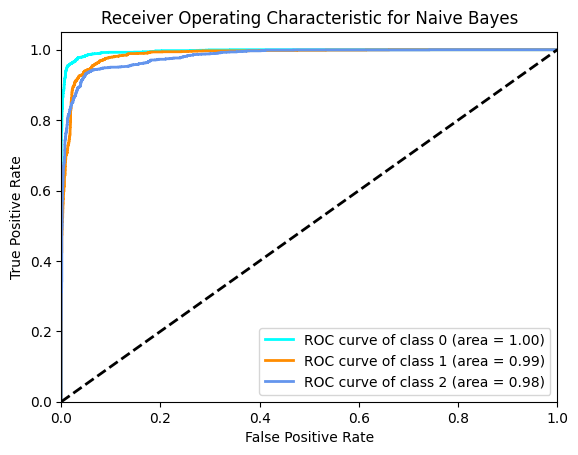

In [7]:
y_pred_cv = cross_val_predict(best_nb_model, X_resampled, y_resampled, cv=skf, method='predict_proba')

# Calculate ROC AUC score for multi-class classification
roc_auc = roc_auc_score(y_resampled, y_pred_cv, multi_class='ovr')
print(f"\nROC AUC Score: {roc_auc}")

y_bin = label_binarize(y_resampled, classes=np.unique(y_resampled))
n_classes = y_bin.shape[1]

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_pred_cv[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
            label=f'ROC curve of class {i} (area = {roc_auc[i]:0.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Naive Bayes')
plt.legend(loc="lower right")
plt.show()

# ROC-AUC SCORE SVM


ROC AUC Score: 0.9924847352789462


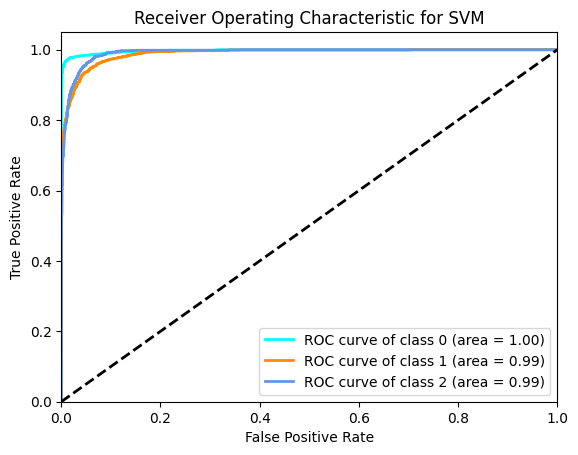

In [8]:
y_pred_cv = cross_val_predict(best_svm_model, X_resampled, y_resampled, cv=skf, method='predict_proba')

# Calculate ROC AUC score for multi-class classification
roc_auc = roc_auc_score(y_resampled, y_pred_cv, multi_class='ovr')
print(f"\nROC AUC Score: {roc_auc}")

y_bin = label_binarize(y_resampled, classes=np.unique(y_resampled))
n_classes = y_bin.shape[1]

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_pred_cv[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
            label=f'ROC curve of class {i} (area = {roc_auc[i]:0.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for SVM')
plt.legend(loc="lower right")
plt.show()

# SAVE MODEL

In [12]:
joblib.dump(best_nb_model, 'output/models/sklearn/naive_bayes_model.pkl')
joblib.dump(best_svm_model, 'output/models/sklearn/svm_model.pkl')

['output/models/sklearn/svm_model.pkl']

# VISUALISASI DATA

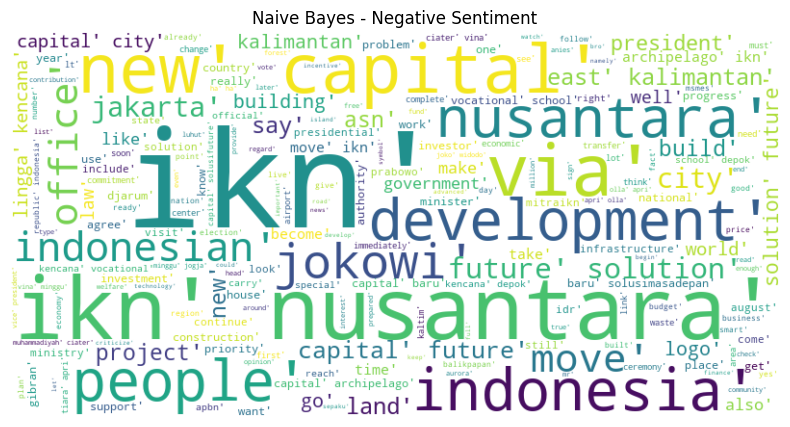

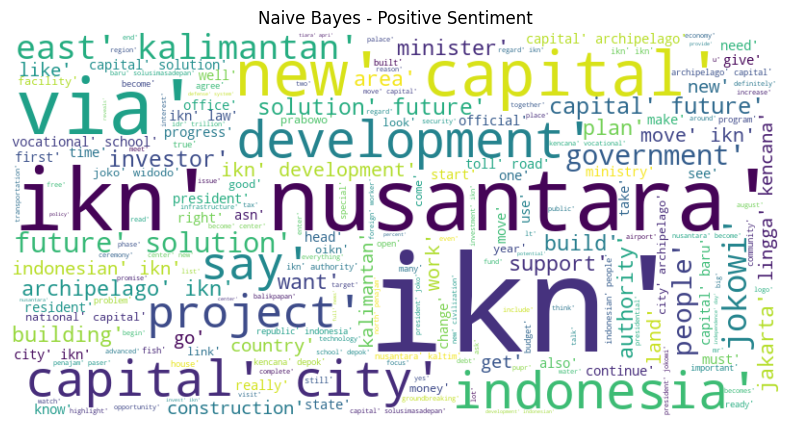

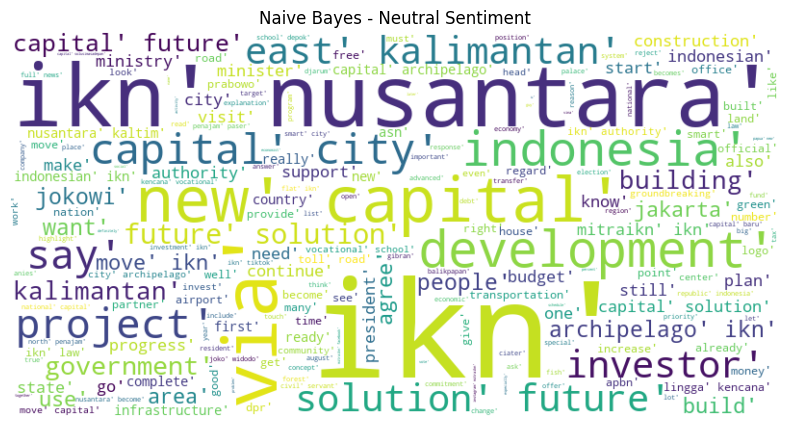

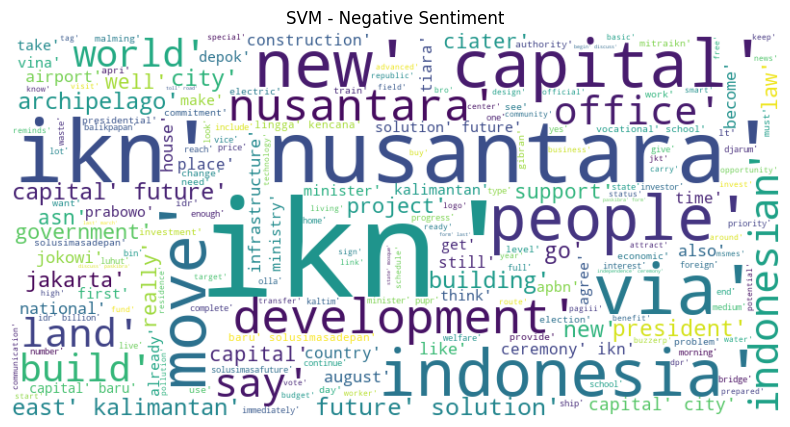

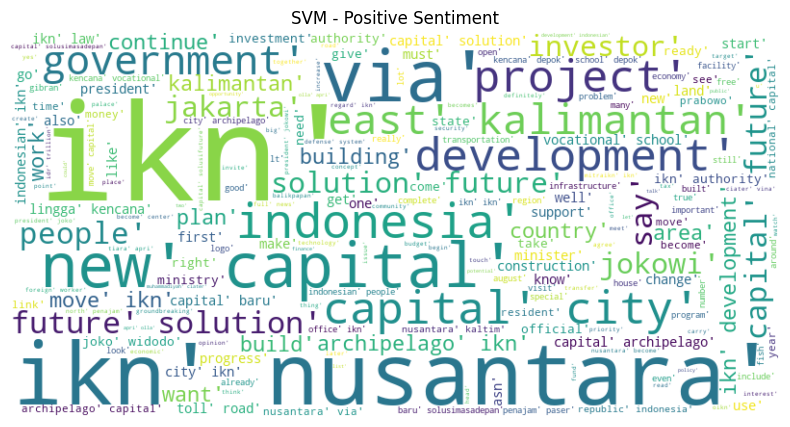

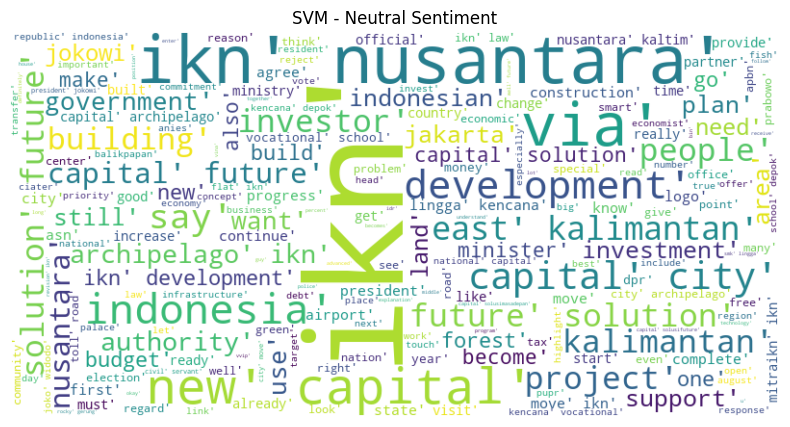

In [21]:
def generate_wordcloud(data, title):
    text = ' '.join(data)
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

# Collect text for each sentiment category based on predictions
def collect_text_by_sentiment(predictions, texts, target_sentiment):
    collected_texts = [texts[i] for i in range(len(texts)) if predictions[i] == target_sentiment]
    return collected_texts

# Generate wordclouds for Naive Bayes
nb_predictions, _ = results['Naive Bayes']
nb_negative_text = collect_text_by_sentiment(nb_predictions, X_cleaned, 'Negative')
nb_positive_text = collect_text_by_sentiment(nb_predictions, X_cleaned, 'Positive')
nb_neutral_text = collect_text_by_sentiment(nb_predictions, X_cleaned, 'Neutral')

generate_wordcloud(nb_negative_text, "Naive Bayes - Negative Sentiment")
generate_wordcloud(nb_positive_text, "Naive Bayes - Positive Sentiment")
generate_wordcloud(nb_neutral_text, "Naive Bayes - Neutral Sentiment")

# Generate wordclouds for SVM
svm_predictions, _ = results['SVM']
svm_negative_text = collect_text_by_sentiment(svm_predictions, X_cleaned, 'Negative')
svm_positive_text = collect_text_by_sentiment(svm_predictions, X_cleaned, 'Positive')
svm_neutral_text = collect_text_by_sentiment(svm_predictions, X_cleaned, 'Neutral')

generate_wordcloud(svm_negative_text, "SVM - Negative Sentiment")
generate_wordcloud(svm_positive_text, "SVM - Positive Sentiment")
generate_wordcloud(svm_neutral_text, "SVM - Neutral Sentiment")